# R/Pythonではじめる計算論的精神医学 5章(python移植版)
- 本ノートブックは、書籍「[R/Pythonではじめる計算論的精神医学(金芳堂)](https://www.kinpodo-pub.co.jp/book/2044-3/)」のサンプルコードとして[github](https://github.com/CPcolloquium/cp_programming_book)に公開されているコードの, 第5章のノートブックを, 学習目的にPythonに移植したものです.
- 著作権への配慮として, 公開されているコードの処理内容をPythonで実装するに留め, セクション番号以外のコメントは反映しておりません.
- 本資料の内容に誤りがあり, それにより利用者または第三者に損害が生じた場合でも, 当方は一切の責任を負いかねますので, あらかじめご了承ください.

### 各種前準備

In [1]:
!pip install matplotlib_fontja
!pip install pingouin

  Using cached pingouin-0.5.5-py3-none-any.whl.metadata (19 kB)
  Using cached pandas_flavor-0.7.0-py3-none-any.whl.metadata (6.7 kB)
Using cached pingouin-0.5.5-py3-none-any.whl (204 kB)
Using cached pandas_flavor-0.7.0-py3-none-any.whl (8.4 kB)


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib_fontja
import seaborn as sns

from scipy.optimize import minimize
import pingouin as pg

import requests
import io

2.2 関数の作成(課題設定用コード)

In [3]:
def func_TaskSetting(pA=0.8):
    df=pd.DataFrame({
        'block': [1]*80+[2]*80,
        'trial': [i+1 for i in range(160)],
        'outA': np.r_[np.random.choice([1, 0], 80, p=[pA, 1-pA], replace=True), np.random.choice([1, 0], 80, p=[1-pA, pA], replace=True)],
        'outB': np.r_[np.random.choice([1, 0], 80, p=[1-pA, pA], replace=True), np.random.choice([1, 0], 80, p=[pA, 1-pA], replace=True)]
    })
    return df

In [4]:
np.random.seed(123)
setting=func_TaskSetting()

In [5]:
setting.head(10)

,block,trial,outA,outB
0,1,1,1,0
1,1,2,1,0
2,1,3,1,0
3,1,4,1,1
4,1,5,1,0
5,1,6,1,0
6,1,7,0,0
7,1,8,1,0
8,1,9,1,0
9,1,10,1,0


In [6]:
setting.rename(columns={'outA': 'A', 'outB': 'B'}).groupby('block')[['A', 'B']].mean()

,A,B
block,,
1,0.875,0.2375
2,0.150,0.7875


2.3 課題設定の可視化

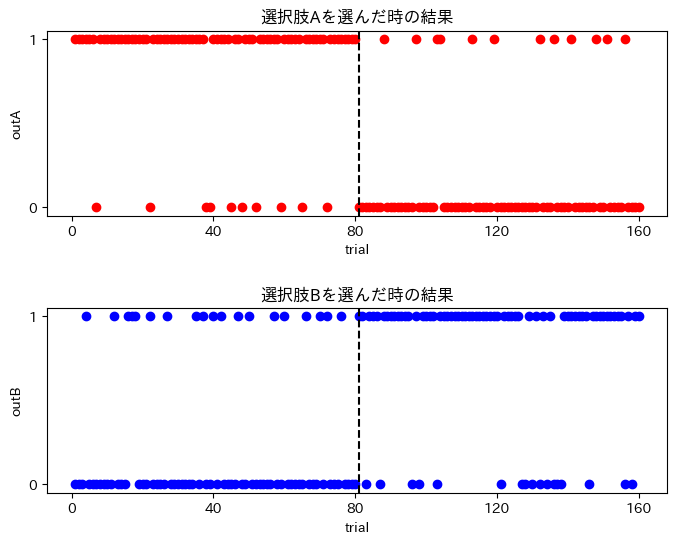

In [7]:
fig=plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.5)

ax1=fig.add_subplot(2, 1, 1)
ax1.scatter(setting['trial'], setting['outA'], color='red')
ax1.axvline(81, linestyle='--', color='black')
ax1.set_xlabel('trial')
ax1.set_ylabel('outA')
ax1.xaxis.set_major_locator(MultipleLocator(40))
ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.set_title('選択肢Aを選んだ時の結果')

ax2=fig.add_subplot(2, 1, 2)
ax2.scatter(setting['trial'], setting['outB'], color='blue')
ax2.axvline(81, linestyle='--', color='black')
ax2.set_xlabel('trial')
ax2.set_ylabel('outB')
ax2.xaxis.set_major_locator(MultipleLocator(40))
ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.set_title('選択肢Bを選んだ時の結果')
fig.show()

3.1 価値の更新

In [8]:
alpha=0.2
Q=0.4
R=1

Q=Q+alpha*(R-Q)
Q

0.52

In [9]:
alphas=np.arange(6)*0.2
for i in alphas:
    alpha=i
    Q=0.4
    R=1
    Q=Q+alpha*(R-Q)
    print(f'alpha: {alpha:.1f}, 更新後のQ値: {Q}')

alpha: 0.0, 更新後のQ値: 0.4
alpha: 0.2, 更新後のQ値: 0.52
alpha: 0.4, 更新後のQ値: 0.64
alpha: 0.6, 更新後のQ値: 0.76
alpha: 0.8, 更新後のQ値: 0.88
alpha: 1.0, 更新後のQ値: 1.0


In [10]:
alpha=0.2
Q=[None]*5
Q[0]=0.5
R=[1, 1, 0, 1, 1]

for t in range(4):
    Q[t+1]=Q[t]+alpha*(R[t]-Q[t])

In [11]:
[[i+1, Q[i]] for i in range(5)]

[[1, 0.5],
 [2, 0.6],
 [3, 0.6799999999999999],
 [4, 0.5439999999999999],
 [5, 0.6352]]

3.2 選択確率の計算

In [12]:
beta=5
Q_A=1.0
Q_B=0.8
P_A=1/(1+np.exp(-beta*(Q_A-Q_B)))
P_B=1-P_A

print(f'Aの選択確率: {P_A}')
print(f'Bの選択確率: {P_B}')

Aの選択確率: 0.7310585786300049
Bの選択確率: 0.2689414213699951


3.3 選択

In [13]:
P_A=0.8
c=[]
if P_A>np.random.rand():
    c+=['A']
else:
    c+=['B']
c

['A']

In [14]:
np.random.seed(123)
c=[None]*100
P_A=0.8
for i in range(100):
    if P_A>np.random.rand():
        c[i]=1
    else:
        c[i]=2

np.c_[np.unique(c, return_counts=True)].T

array([[ 1,  2],
       [87, 13]])

4.1 関数の作成(データ生成用コード)

In [15]:
def func_DataGeneration(param, setting):
    alpha=param[0]
    beta=param[1]

    outA=setting['outA'].values
    outB=setting['outB'].values
    trials=setting['trial'].values
    Ntrial=len(trials)

    c=[None]*Ntrial
    r=[None]*Ntrial
    Q_A=[None]*Ntrial
    Q_B=[None]*Ntrial
    p_A=[None]*Ntrial
    RPE=[None]*Ntrial

    Q_A[0]=0.5
    Q_B[0]=0.5

    for t in range(Ntrial):
        p_A[t]=np.exp(beta*Q_A[t])/(np.exp(beta*Q_A[t])+np.exp(beta*Q_B[t]))

        if p_A[t]>np.random.rand():
            c[t]=1
            r[t]=outA[t]
            RPE[t]=r[t]-Q_A[t]
        else:
            c[t]=2
            r[t]=outB[t]
            RPE[t]=r[t]-Q_B[t]

        if t<Ntrial-1:
            if c[t]==1:
                Q_A[t+1]=Q_A[t]+alpha*RPE[t]
                Q_B[t+1]=Q_B[t]

            if c[t]==2:
                Q_B[t+1]=Q_B[t]+alpha*RPE[t]
                Q_A[t+1]=Q_A[t]

    df=pd.DataFrame({
        'trial': trials,
        'QA': Q_A,
        'QB': Q_B,
        'choice': c,
        'reward': r,
        'pA': p_A,
        'pB': [1-p for p in p_A],
        'RPE': RPE
    })

    return df

4.2 1人分のデータ生成

In [16]:
np.random.seed(123)
tmp_param=[0.2, 5]
tmp_setting=func_TaskSetting(0.8)

In [17]:
res=func_DataGeneration(tmp_param, tmp_setting)
print(res)

     trial        QA        QB  choice  reward        pA        pB       RPE
0        1  0.500000  0.500000       1       1  0.500000  0.500000  0.500000
1        2  0.600000  0.500000       1       1  0.622459  0.377541  0.400000
2        3  0.680000  0.500000       2       0  0.710950  0.289050 -0.500000
3        4  0.680000  0.400000       1       1  0.802184  0.197816  0.320000
4        5  0.744000  0.400000       1       1  0.848129  0.151871  0.256000
..     ...       ...       ...     ...     ...       ...       ...       ...
155    156  0.085525  0.960494       2       0  0.012434  0.987566 -0.960494
156    157  0.085525  0.768395       2       1  0.031850  0.968150  0.231605
157    158  0.085525  0.814716       2       0  0.025433  0.974567 -0.814716
158    159  0.085525  0.651773       2       1  0.055659  0.944341  0.348227
159    160  0.085525  0.721418       2       1  0.039946  0.960054  0.278582

[160 rows x 8 columns]


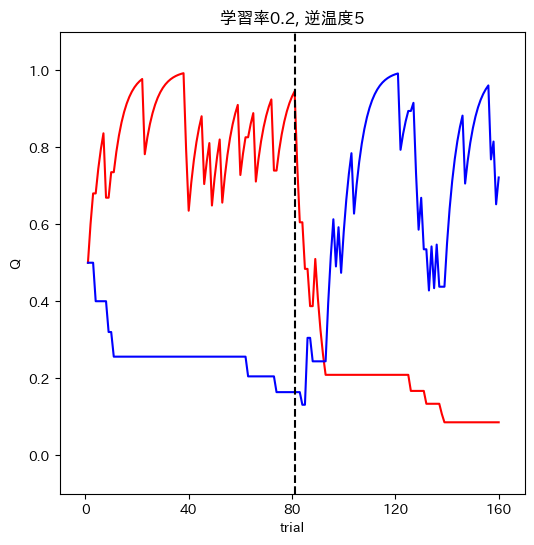

In [18]:
fig=plt.figure(figsize=(6, 6))
ax=fig.add_subplot(1, 1, 1)
ax.plot(res['trial'], res['QA'], color='red')
ax.plot(res['trial'], res['QB'], color='blue')
ax.axvline(81, linestyle='--', color='black')
ax.set_xlabel('trial')
ax.set_ylabel('Q')
ax.set_xlim(-10, 170)
ax.set_ylim(-0.1, 1.1)
ax.xaxis.set_major_locator(MultipleLocator(40))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.set_title(f'学習率{tmp_param[0]}, 逆温度{tmp_param[1]}')
fig.show()

4.3 100人分のデータ生成

In [19]:
Nsim=100

res100=pd.DataFrame()
np.random.seed(123)
tmp_param=[0.2, 5]

for i in range(Nsim):
    tmp_setting=func_TaskSetting()
    res=func_DataGeneration(param=tmp_param, setting=tmp_setting)
    res=pd.merge(res, tmp_setting, left_on='trial', right_on='trial', how='left')
    res.insert(0, 'id', i)

    res100=pd.concat([res100, res])

In [20]:
res100.shape

(16000, 12)

In [21]:
res100.head(10)

,id,trial,QA,QB,choice,reward,pA,pB,RPE,block,outA,outB
0,0,1,0.500000,0.50,1,1,0.500000,0.500000,0.500000,1,1,0
1,0,2,0.600000,0.50,1,1,0.622459,0.377541,0.400000,1,1,0
2,0,3,0.680000,0.50,2,0,0.710950,0.289050,-0.500000,1,1,0
3,0,4,0.680000,0.40,1,1,0.802184,0.197816,0.320000,1,1,1
4,0,5,0.744000,0.40,1,1,0.848129,0.151871,0.256000,1,1,0
5,0,6,0.795200,0.40,1,1,0.878254,0.121746,0.204800,1,1,0
6,0,7,0.836160,0.40,1,0,0.898512,0.101488,-0.836160,1,0,0
7,0,8,0.668928,0.40,2,0,0.793252,0.206748,-0.400000,1,1,0
8,0,9,0.668928,0.32,1,1,0.851275,0.148725,0.331072,1,1,0
9,0,10,0.735142,0.32,2,0,0.888520,0.111480,-0.320000,1,1,0


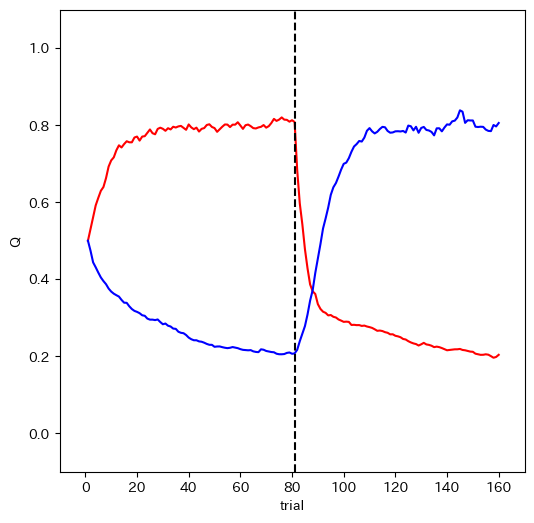

In [22]:
fig=plt.figure(figsize=(6, 6))
ax=fig.add_subplot(1, 1, 1)
ax.plot(np.arange(160)+1, res100.groupby('trial')['QA'].mean().values, color='red')
ax.plot(np.arange(160)+1, res100.groupby('trial')['QB'].mean().values, color='blue')
ax.axvline(81, linestyle='--', color='black')
ax.set_xlabel('trial')
ax.set_ylabel('Q')
ax.set_xlim(-10, 170)
ax.set_ylim(-0.1, 1.1)
fig.show()

5.1 サンプルデータの確認

In [23]:
url = 'https://x.gd/Ne4xj'
res = requests.get(url).content
data = pd.read_csv(io.StringIO(res.decode('utf-8')), header=0)

In [24]:
data.head(10)

,group,id,block,trial,choice,reward
0,P,1,1,1,2,0
1,P,1,1,2,1,1
2,P,1,1,3,1,1
3,P,1,1,4,2,0
4,P,1,1,5,1,0
5,P,1,1,6,1,1
6,P,1,1,7,2,0
7,P,1,1,8,1,0
8,P,1,1,9,1,1
9,P,1,1,10,2,0


5.3 関数の作成(対数尤度を算出するコード)

In [25]:
def func_LogLik(param, data):
    alpha=param[0]
    beta=param[1]

    trials=data['trial']
    Ntrial=len(trials)
    c=data['choice']
    r=data['reward']

    Q_A=[None]*Ntrial
    Q_B=[None]*Ntrial
    p_A=[None]*Ntrial
    RPE=[None]*Ntrial

    Q_A[0]=0.5
    Q_B[0]=0.5

    logLik=0

    for t in range(Ntrial):
        p_A[t]=np.exp(beta*Q_A[t])/(np.exp(beta*Q_A[t])+np.exp(beta*Q_B[t]))

        if c[t]==1:
            RPE[t]=r[t]-Q_A[t]
            logLik=logLik+np.log(max(p_A[t], 1e-14))  #logの安定化のため1e-14を下限にしている

        if c[t]==2:
            RPE[t]=r[t]-Q_B[t]
            logLik=logLik+np.log(max(1-p_A[t], 1e-14))  #logの安定化のため1e-14を下限にしている

        if t<Ntrial-1:
            if c[t]==1:
                Q_A[t+1]=Q_A[t]+alpha*RPE[t]
                Q_B[t+1]=Q_B[t]

            if c[t]==2:
                Q_B[t+1]=Q_B[t]+alpha*RPE[t]
                Q_A[t+1]=Q_A[t]

    return logLik

In [26]:
data1=data.loc[data['id']==1, :]

In [27]:
betas=np.arange(0.05, 8, 0.05)

LogLik_1=[]

for beta in betas:
    param=[0.2, beta]
    tmp=func_LogLik(param=param, data=data1)
    LogLik_1=LogLik_1+[tmp]

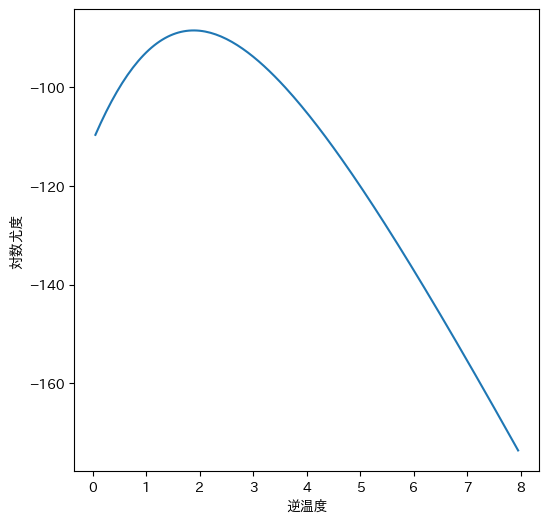

In [28]:
df=pd.DataFrame({
    'beta': betas,
    'LogLik': LogLik_1
})

fig=plt.figure(figsize=(6, 6))
ax=fig.add_subplot(1, 1, 1)
ax.plot(df['beta'], df['LogLik'])
ax.set_xlabel('逆温度')
ax.set_ylabel('対数尤度')
fig.show()

In [29]:
k=np.argmax(LogLik_1)
betas[k]

np.float64(1.9000000000000001)

5.4 optim関数の紹介 (注: 本notebookではscipy.optimizeで代用)

In [30]:
func_negLogLik=lambda param, data: -func_LogLik(param, data)

In [31]:
initparam=np.random.rand(2)
lblist=[0, 0]
ublist=[1, 20]

est=minimize(func_negLogLik, initparam, args=(data1,), method='L-BFGS-B', bounds=list(zip(lblist, ublist)))

In [32]:
est.x

array([0.16076729, 2.00896658])

In [33]:
est.fun

np.float64(88.32542206225776)

5.5 関数の作成(最尤推定を行うコード)

In [34]:
def func_ParamFit(data):
    data=data.reset_index()
    neglogLik=np.inf

    for idx in range(5):
        initparam=np.random.rand(2)
        lblist=[0, 0]
        ublist=[1, 20]

        est=minimize(func_negLogLik, initparam, args=(data.reset_index(),), method='L-BFGS-B', bounds=list(zip(lblist, ublist)))
        print(f'id: {data.id[0]}, NegLogLik: {est.fun:.2f}, Par: {[str(round(x, 2)) for x in est.x]}')

        if est.fun < neglogLik:
            neglogLik=est.fun
            paramest=est.x

    df=pd.DataFrame({
        'id': data.id[0],
        'group': data.group[0],
        'neglogLik': [neglogLik]
    })

    for i in range(len(paramest)):
        df[f'param{i+1}']=paramest[i]

    return df


5.6 パラメータ推定の実行

In [35]:
res=func_ParamFit(data1)

id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']
id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']
id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']
id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']
id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']


In [36]:
res

,id,group,neglogLik,param1,param2
0,1,P,88.325422,0.160767,2.008965


In [37]:
resAll=pd.DataFrame()
for i in np.unique(data.id):
    res=func_ParamFit(data.loc[data.id==i])
    resAll=pd.concat([resAll, res])

id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']
id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']
id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']
id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']
id: 1, NegLogLik: 88.33, Par: ['0.16', '2.01']
id: 2, NegLogLik: 85.26, Par: ['0.24', '2.17']
id: 2, NegLogLik: 85.26, Par: ['0.24', '2.17']
id: 2, NegLogLik: 85.26, Par: ['0.24', '2.17']
id: 2, NegLogLik: 85.26, Par: ['0.24', '2.17']
id: 2, NegLogLik: 85.26, Par: ['0.24', '2.17']
id: 3, NegLogLik: 74.01, Par: ['0.1', '3.21']
id: 3, NegLogLik: 74.01, Par: ['0.1', '3.21']
id: 3, NegLogLik: 74.01, Par: ['0.1', '3.21']
id: 3, NegLogLik: 74.01, Par: ['0.1', '3.21']
id: 3, NegLogLik: 74.01, Par: ['0.1', '3.21']
id: 4, NegLogLik: 89.98, Par: ['0.2', '2.13']
id: 4, NegLogLik: 89.98, Par: ['0.2', '2.13']
id: 4, NegLogLik: 89.98, Par: ['0.2', '2.13']
id: 4, NegLogLik: 89.98, Par: ['0.2', '2.13']
id: 4, NegLogLik: 89.98, Par: ['0.2', '2.13']
id: 5, NegLogLik: 93.56, Par: ['0.12', '2.02']
id: 5, NegLogLik: 93.56

In [38]:
resAll.rename(columns={'param1': 'alpha', 'param2': 'beta'}).groupby('group')[['alpha', 'beta']].mean()

,alpha,beta
group,,
H,0.211098,6.034190
P,0.191162,2.269387


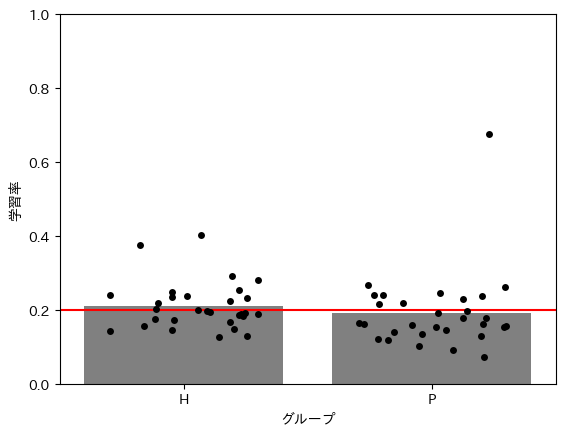

In [39]:
sns.barplot(data=resAll, x='group', y='param1', errorbar=('ci', False), order=['H', 'P'], color='gray')
sns.stripplot(data=resAll, x='group', y='param1', jitter=0.3, order=['H', 'P'], color='black')
plt.axhline(0.2, color='red')
plt.ylim(0, 1.0)
plt.xlabel('グループ')
plt.ylabel('学習率')
plt.show()

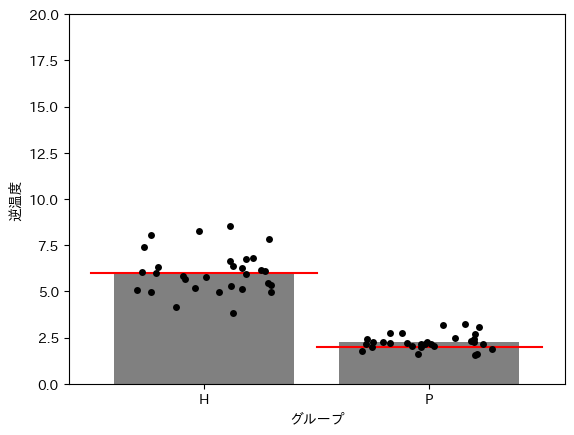

In [40]:
sns.barplot(data=resAll, x='group', y='param2', errorbar=('ci', False), order=['H', 'P'], color='gray')
sns.stripplot(data=resAll, x='group', y='param2', jitter=0.3, order=['H', 'P'], color='black')
plt.plot([-0.5, 0.5], [6, 6], color='red')
plt.plot([0.5, 1.5], [2, 2], color='red')
plt.ylim(0, 20)
plt.xlabel('グループ')
plt.ylabel('逆温度')
plt.show()

6. パラメータリカバリー

In [41]:
np.random.seed(123)
setting=func_TaskSetting()

In [42]:
np.random.seed(123)
Nsim=100
df_pararecovery=pd.DataFrame()

for i in range(Nsim):
    if (i+1)%20==0:
        print(f'progress: {i+1}/{Nsim}')

    true_alpha=np.random.rand()
    true_beta=np.random.exponential(10)
    tmp_param=[true_alpha, true_beta]

    tmp_data=func_DataGeneration(param=tmp_param, setting=setting)
    tmp_data['group']='Simulation'
    tmp_data['id']=i

    res_parafit=func_ParamFit(data=tmp_data)

    df=pd.DataFrame({
        'sim': [i],
        'true_alpha': [true_alpha],
        'true_beta': [true_beta],
        'est_alpha': res_parafit['param1'],
        'est_beta': res_parafit['param2']
    })
    df_pararecovery=pd.concat([df_pararecovery, df])

id: 0, NegLogLik: 31.56, Par: ['0.51', '5.05']
id: 0, NegLogLik: 31.56, Par: ['0.51', '5.05']
id: 0, NegLogLik: 31.56, Par: ['0.51', '5.05']
id: 0, NegLogLik: 31.56, Par: ['0.51', '5.05']
id: 0, NegLogLik: 31.56, Par: ['0.51', '5.05']
id: 1, NegLogLik: 24.59, Par: ['0.92', '20.0']
id: 1, NegLogLik: 24.59, Par: ['0.92', '20.0']
id: 1, NegLogLik: 24.59, Par: ['0.92', '20.0']
id: 1, NegLogLik: 24.59, Par: ['0.92', '20.0']
id: 1, NegLogLik: 24.59, Par: ['0.92', '20.0']
id: 2, NegLogLik: 82.63, Par: ['0.15', '2.75']
id: 2, NegLogLik: 82.63, Par: ['0.15', '2.75']
id: 2, NegLogLik: 82.63, Par: ['0.15', '2.75']
id: 2, NegLogLik: 82.63, Par: ['0.15', '2.75']
id: 2, NegLogLik: 82.63, Par: ['0.15', '2.75']
id: 3, NegLogLik: 4.84, Par: ['0.38', '20.0']
id: 3, NegLogLik: 4.84, Par: ['0.38', '20.0']
id: 3, NegLogLik: 4.84, Par: ['0.38', '20.0']
id: 3, NegLogLik: 4.84, Par: ['0.38', '20.0']
id: 3, NegLogLik: 4.84, Par: ['0.38', '20.0']
id: 4, NegLogLik: 93.19, Par: ['0.09', '2.2']
id: 4, NegLogLik: 9

In [43]:
df_pararecovery.head(10)

,sim,true_alpha,true_beta,est_alpha,est_beta
0,0,0.696469,3.370675,0.506996,5.054623
0,1,0.859389,17.231897,0.915374,20.000000
0,2,0.273842,2.308168,0.148103,2.749994
0,3,0.441324,27.007152,0.375290,20.000000
0,4,0.097160,2.316586,0.094926,2.195842
0,5,0.673936,35.098481,0.640022,20.000000
0,6,0.045130,1.874976,0.236443,0.981882
0,7,0.593238,2.607461,0.606487,2.172506
0,8,0.589985,1.383619,1.000000,0.760973
0,9,0.061808,4.887912,0.068368,4.421317


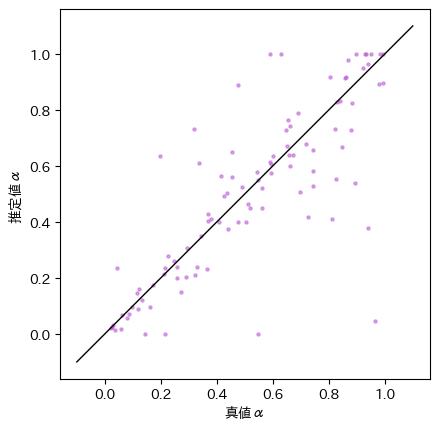

In [44]:
plt.plot([-0.1, 1.1], [-0.1, 1.1], color='black', lw=1)
plt.scatter(df_pararecovery['true_alpha'], df_pararecovery['est_alpha'], color='mediumorchid', s=5, alpha=0.5)
plt.xlabel('真値α')
plt.ylabel('推定値α')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [45]:
pg.corr(df_pararecovery['true_alpha'], df_pararecovery['est_alpha'], method='pearson')

,n,r,CI95%,p-val,BF10,power
pearson,100,0.810461,"[0.73, 0.87]",1.710453e-24,2.55e+21,1.0


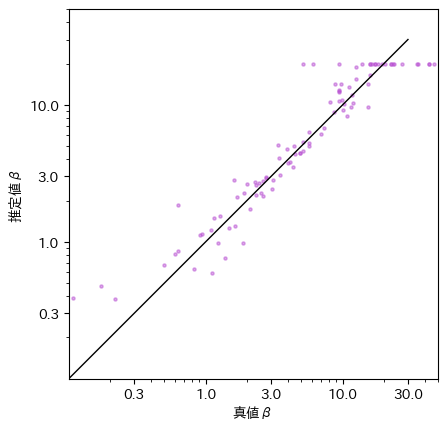

In [46]:
plt.plot([0.1, 30], [0.1, 30], color='black', lw=1)
plt.scatter(df_pararecovery['true_beta'], df_pararecovery['est_beta'], color='mediumorchid', s=5, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticks([0.3, 1.0, 3.0, 10.0, 30.0])
plt.gca().set_yticks([0.3, 1.0, 3.0, 10.0])
plt.gca().set_xticklabels([0.3, 1.0, 3.0, 10.0, 30.0])
plt.gca().set_yticklabels([0.3, 1.0, 3.0, 10.0])
plt.xlabel('真値β')
plt.ylabel('推定値β')
plt.xlim(0.1, 50)
plt.ylim(0.1, 50)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [47]:
pg.corr(df_pararecovery['true_beta'], df_pararecovery['est_beta'], method='pearson')

,n,r,CI95%,p-val,BF10,power
pearson,100,0.762709,"[0.67, 0.83]",2.961093e-20,1.897e+17,1.0


7.1 学習率の非対称性を組み込んだモデル

In [48]:
def func_LogLik(param, data, model='Model1'):
    if model=='Model1':
        alpha=param[0]
        beta=param[1]
    elif model=='Model2':
        alphaP=param[0]
        alphaN=param[1]
        beta=param[2]

    trials=data['trial']
    Ntrial=len(trials)
    c=data['choice']
    r=data['reward']

    Q_A=[None]*Ntrial
    Q_B=[None]*Ntrial
    p_A=[None]*Ntrial
    RPE=[None]*Ntrial

    Q_A[0]=0.5
    Q_B[0]=0.5

    logLik=0

    for t in range(Ntrial):
        p_A[t]=np.exp(beta*Q_A[t])/(np.exp(beta*Q_A[t])+np.exp(beta*Q_B[t]))

        if c[t]==1:
            RPE[t]=r[t]-Q_A[t]
            logLik=logLik+np.log(max(p_A[t], 1e-14))  #logの安定化のため1e-14を下限にしている

        if c[t]==2:
            RPE[t]=r[t]-Q_B[t]
            logLik=logLik+np.log(max(1-p_A[t], 1e-14))  #logの安定化のため1e-14を下限にしている

        if t<Ntrial-1:
            if (model=='Model2') & (RPE[t]>=0):
                alpha=alphaP
            elif (model=='Model2') & (RPE[t]<0):
                alpha=alphaN

            if c[t]==1:
                Q_A[t+1]=Q_A[t]+alpha*RPE[t]
                Q_B[t+1]=Q_B[t]

            if c[t]==2:
                Q_B[t+1]=Q_B[t]+alpha*RPE[t]
                Q_A[t+1]=Q_A[t]

    return logLik

In [49]:
func_negLogLik=lambda param, data, model='Model1': -func_LogLik(param, data, model)

In [50]:
def func_ParamFit(data, model='Model1'):
    data=data.reset_index()
    neglogLik=np.inf

    for idx in range(5):
        if model=='Model1':
            initparam=np.random.rand(2)
        elif model=='Model2':
            initparam=np.random.rand(3)

        if model=='Model1':
            lblist=[0, 0]
            ublist=[1, 20]
        elif model=='Model2':
            lblist=[0, 0, 0]
            ublist=[1, 1, 20]

        est=minimize(func_negLogLik, initparam, args=(data, model), method='L-BFGS-B', bounds=list(zip(lblist, ublist)), options={'disp': False})
        #print(f'id: {data.id[0]}, NegLogLik: {est.fun:.2f}, Par: {[str(round(x, 2)) for x in est.x]}')

        if est.fun<neglogLik:
            neglogLik=est.fun
            paramest=est.x

    df=pd.DataFrame({
        'id': data.id[0],
        'group': data.group[0],
        'neglogLik': [neglogLik],
    })

    for i in range(len(paramest)):
        df[f'param{i+1}']=paramest[i]

    return df

7.2 モデル比較の実行

In [51]:
url = 'https://x.gd/Ne4xj'
res = requests.get(url).content
data = pd.read_csv(io.StringIO(res.decode('utf-8')), header=0)

In [52]:
df_M1=pd.DataFrame()
for i in np.unique(data['id']):
    tmp_data=data.loc[data.id==i, :]
    res=func_ParamFit(tmp_data, model='Model1')
    df_M1=pd.concat([df_M1, res])

In [53]:
df_M1['AIC']=2*df_M1['neglogLik']+2*2
df_M1['BIC']=2*df_M1['neglogLik']+2*np.log(160)

In [54]:
df_M2=pd.DataFrame()
for i in np.unique(data['id']):
    tmp_data=data.loc[data.id==i, :]
    res=func_ParamFit(tmp_data, model='Model2')
    df_M2=pd.concat([df_M2, res])

In [55]:
df_M2['AIC']=2*df_M2['neglogLik']+2*3
df_M2['BIC']=2*df_M2['neglogLik']+3*np.log(160)

In [56]:
print(f'[Model1] AIC: {df_M1.AIC.sum():.2f}, BIC: {df_M1.BIC.sum():.2f}')
print(f'[Model2] AIC: {df_M2.AIC.sum():.2f}, BIC: {df_M2.BIC.sum():.2f}')

[Model1] AIC: 8005.82, BIC: 8374.84
[Model2] AIC: 8051.62, BIC: 8605.15
